<a href="https://colab.research.google.com/github/BdsKlause/BdsKlause/blob/main/aurum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nltk
!pip install pandas
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 16.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#nlp
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

## Data loading

### Subtask:
Load the dataset.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/My Drive/aurum/sentimentdataset_with_scores.csv')
display(df.head())

,unnamed,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,1,Enjoying a beautiful day at the park! ...,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,2,Traffic was terrible this morning. ...,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,3,Just finished an amazing workout! ?? ...,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,4,Excited about the upcoming weekend getaway! ...,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,5,Trying out a new recipe for dinner tonight. ...,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


## Data exploration

### Subtask:
Explore the loaded dataset to understand its characteristics.


Shape of the DataFrame: (732, 15)

Data Types:
unnamed                 int64
Text                   object
Timestamp              object
User                   object
Platform               object
Hashtags               object
Retweets                int64
Likes                   int64
Country                object
Year                    int64
Month                   int64
Day                     int64
Hour                    int64
sentiment_score       float64
sentiment_category     object
dtype: object

Missing Values:
unnamed               0
Text                  0
Timestamp             0
User                  0
Platform              0
Hashtags              0
Retweets              0
Likes                 0
Country               0
Year                  0
Month                 0
Day                   0
Hour                  0
sentiment_score       0
sentiment_category    0
dtype: int64

Descriptive statistics for 'sentiment_score':
count    732.000000
mean       0.255119
std        0

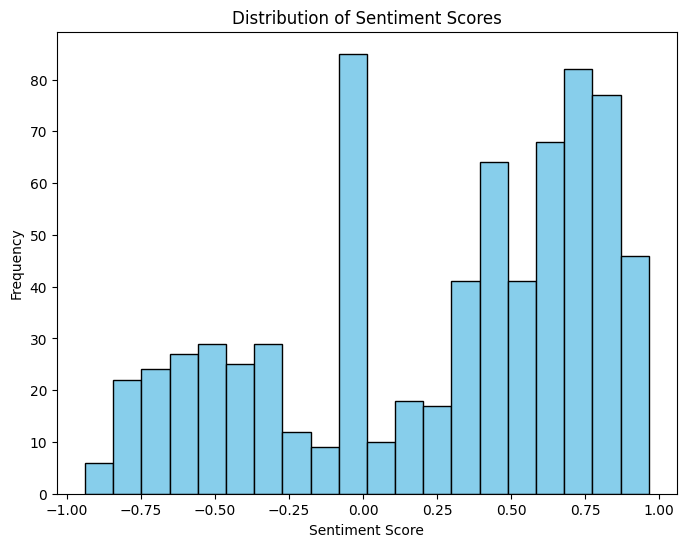

In [6]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine data types
print("\nData Types:")
print(df.dtypes)

# Identify the text column (assuming it's named 'Text' or similar)
text_column = 'Text'  # Replace with the actual column name if different

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Analyze the distribution of 'sentiment_score'
print("\nDescriptive statistics for 'sentiment_score':")
print(df['sentiment_score'].describe())

# Analyze the distribution of 'sentiment_category'
print("\nUnique values and counts in 'sentiment_category':")
print(df['sentiment_category'].value_counts())

# Basic visualization (histogram for sentiment score)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.hist(df['sentiment_score'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

## Data cleaning

### Subtask:
Clean the text data in the 'Text' column of the DataFrame `df`.


In [7]:
df.columns

Index(['unnamed', 'Text', 'Timestamp', 'User', 'Platform', 'Hashtags',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour',
       'sentiment_score', 'sentiment_category'],
      dtype='object')

In [8]:
df.drop("unnamed", axis=1, inplace=True)

In [9]:

# Define a robust text cleaning function
def clean_text(text):
    if isinstance(text, str):
        text = unidecode(text)  # Normalize accented characters like é -> e
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
        text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces/newlines with a single space
        text = text.strip().lower()  # Trim and convert to lowercase
    else:
        text = ""
    return text

# Apply cleaning to the 'Text' column
df['Text'] = df['Text'].apply(clean_text)

# Display the first few cleaned rows
display(df.head())

# Optional: Show a few before-and-after samples for verification
print("🧼 Sample cleaning preview:")
for i in range(3):
    raw_text = df['Text'].iloc[i]
    cleaned_text = clean_text(raw_text)
    print(f"Original [{i}]:", raw_text)
    print(f"Cleaned  [{i}]:", cleaned_text)
    print("-" * 40)

,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,enjoying a beautiful day at the park,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,traffic was terrible this morning,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,just finished an amazing workout,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,excited about the upcoming weekend getaway,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,trying out a new recipe for dinner tonight,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


🧼 Sample cleaning preview:
Original [0]: enjoying a beautiful day at the park
Cleaned  [0]: enjoying a beautiful day at the park
----------------------------------------
Original [1]: traffic was terrible this morning
Cleaned  [1]: traffic was terrible this morning
----------------------------------------
Original [2]: just finished an amazing workout
Cleaned  [2]: just finished an amazing workout
----------------------------------------


In [10]:
# Download 'punkt_tab' before tokenization
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def advanced_clean_text(text):
    if isinstance(text, str):
        text = unidecode(text)  # Normalize accents
        text = re.sub(r'http\S+|@\w+|#\w+', '', text)  # Remove URLs, mentions, hashtags
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and digits
        text = re.sub(r'\s+', ' ', text).strip().lower()  # Normalize spaces and lowercase
        tokens = nltk.word_tokenize(text)  # Tokenize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
        return ' '.join(tokens)
    return ""

df['Cleaned_Text'] = df['Text'].apply(advanced_clean_text)
display(df[['Text', 'Cleaned_Text']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Text,Cleaned_Text
0,enjoying a beautiful day at the park,enjoying beautiful day park
1,traffic was terrible this morning,traffic terrible morning
2,just finished an amazing workout,finished amazing workout
3,excited about the upcoming weekend getaway,excited upcoming weekend getaway
4,trying out a new recipe for dinner tonight,trying new recipe dinner tonight


## Data preparation

### Subtask:
Prepare the data for modeling by splitting it into training, validation, and testing sets, and performing necessary text transformations for each model (Logistic Regression and LSTM).


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Define features (X) and target variables (y)
X = df['Text']
y_score = df['sentiment_score']
y_category = df['sentiment_category']

# Split data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train_score, y_temp_score, y_train_category, y_temp_category = train_test_split(
    X, y_score, y_category, test_size=0.2, random_state=42
)
X_val, X_test, y_val_score, y_test_score, y_val_category, y_test_category = train_test_split(
    X_temp, y_temp_score, y_temp_category, test_size=0.5, random_state=42
)

# Logistic Regression Preparation: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# LSTM preparation Tokenization and Sequencing
max_sequence_length = 100  # Adjust as needed
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Limit vocabulary size
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val_seq = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_seq = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Convert target variables to numpy arrays for LSTM
y_train_score = np.array(y_train_score)
y_val_score = np.array(y_val_score)
y_test_score = np.array(y_test_score)

# For simplicity, convert sentiment category to numerical representation for LSTM
category_mapping = {'Positive': 2, 'Negative': 1, 'Neutral': 0}
y_train_category = np.array([category_mapping[category] for category in y_train_category])
y_val_category = np.array([category_mapping[category] for category in y_val_category])
y_test_category = np.array([category_mapping[category] for category in y_test_category])

# Check the sizes of the datasets after processing
print(f"Train set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")


Train set size: 585
Validation set size: 73
Test set size: 74


In [12]:
#Data preparation for LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")  # Adjust vocab size as needed
tokenizer.fit_on_texts(df['Cleaned_Text']) # Fit on the cleaned text
sequences = tokenizer.texts_to_sequences(df['Cleaned_Text'])

# 2. Padding/Truncating
max_length = 100  # Adjust sequence length as needed
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# 3. Splitting (Assuming you already have X_train, X_val, X_test from previous steps)
X_train_lstm = padded_sequences[X_train.index]
X_val_lstm = padded_sequences[X_val.index]
X_test_lstm = padded_sequences[X_test.index]

# Assuming you have y_train_category, y_val_category, y_test_category from before
# These are your target labels for sentiment categories (Positive, Negative, Neutral)

## Splitting the dataset

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer with a limit of 5000 features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test data using the fitted vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shape of the resulting TF-IDF matrices
print(f"TF-IDF training matrix shape: {X_train_tfidf.shape}")
print(f"TF-IDF validation matrix shape: {X_val_tfidf.shape}")
print(f"TF-IDF test matrix shape: {X_test_tfidf.shape}")


TF-IDF training matrix shape: (585, 2259)
TF-IDF validation matrix shape: (73, 2259)
TF-IDF test matrix shape: (74, 2259)


# Prediction for Sentiment Classification.

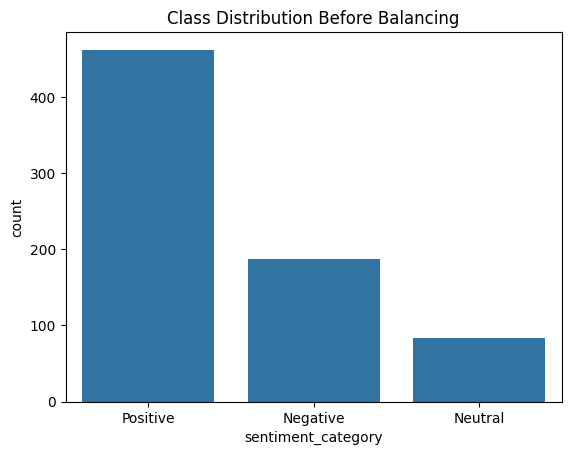

sentiment_category
Positive    462
Negative    187
Neutral      83
Name: count, dtype: int64


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment_category')
plt.title("Class Distribution Before Balancing")
plt.show()

print(df['sentiment_category'].value_counts())


In [15]:
from imblearn.over_sampling import SMOTE

# Only apply SMOTE on the training TF-IDF features and category labels
smote = SMOTE(random_state=42)
X_train_tfidf_balanced, y_train_category_balanced = smote.fit_resample(X_train_tfidf, y_train_category)

# Check new class distribution
from collections import Counter
print("New training label distribution after SMOTE:", Counter(y_train_category_balanced))


New training label distribution after SMOTE: Counter({np.int64(2): 368, np.int64(1): 368, np.int64(0): 368})


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the Logistic Regression classifier
clf_category = LogisticRegression(max_iter=1000, random_state=42)
clf_category.fit(X_train_tfidf_balanced, y_train_category_balanced)

# Predict on the validation set
y_val_pred_category = clf_category.predict(X_val_tfidf)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(y_val_category, y_val_pred_category))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_val_category, y_val_pred_category))

print("\nAccuracy Score:", accuracy_score(y_val_category, y_val_pred_category))



Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         6
           1       0.86      0.78      0.82        23
           2       0.83      0.86      0.84        44

    accuracy                           0.81        73
   macro avg       0.73      0.72      0.72        73
weighted avg       0.81      0.81      0.81        73


Confusion Matrix:

[[ 3  0  3]
 [ 0 18  5]
 [ 3  3 38]]

Accuracy Score: 0.8082191780821918


In [17]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
clf_category = LogisticRegression(max_iter=1000, class_weight="balanced",random_state=42)

# Fit the model on the training set
clf_category.fit(X_train_tfidf, y_train_category)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on validation data
y_val_pred_category = clf_category.predict(X_val_tfidf)

# Evaluation metrics
print("📋 Classification Report:\n")
print(classification_report(y_val_category, y_val_pred_category, target_names=['Negative', 'Neutral', 'Positive']))

print("\n✅ Accuracy Score:", accuracy_score(y_val_category, y_val_pred_category))


📋 Classification Report:

              precision    recall  f1-score   support

    Negative       0.33      0.50      0.40         6
     Neutral       0.83      0.87      0.85        23
    Positive       0.88      0.80      0.83        44

    accuracy                           0.79        73
   macro avg       0.68      0.72      0.69        73
weighted avg       0.82      0.79      0.80        73


✅ Accuracy Score: 0.7945205479452054


In [19]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization type (l1/l2)
    'solver': ['lbfgs', 'liblinear'],  # Solvers
    'max_iter': [500, 1000]  # Iterations for convergence
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

# Fit the model
grid_search.fit(X_train_tfidf_balanced, y_train_category_balanced)

# Get best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the validation set with the best model
y_val_pred_category_tuned = grid_search.best_estimator_.predict(X_val_tfidf)

# Evaluate the tuned model
print("📋 Classification Report (After Hyperparameter Tuning):")
print(classification_report(y_val_category, y_val_pred_category_tuned))

print("\n🔁 Confusion Matrix:")
print(confusion_matrix(y_val_category, y_val_pred_category_tuned))

print("\n✅ Accuracy Score:", accuracy_score(y_val_category, y_val_pred_category_tuned))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
📋 Classification Report (After Hyperparameter Tuning):
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         6
           1       0.90      0.83      0.86        23
           2       0.83      0.86      0.84        44

    accuracy                           0.81        73
   macro avg       0.69      0.67      0.68        73
weighted avg       0.81      0.81      0.81        73


🔁 Confusion Matrix:
[[ 2  0  4]
 [ 0 19  4]
 [ 4  2 38]]

✅ Accuracy Score: 0.8082191780821918


## Model evaluation

### Subtask:
Evaluate the performance of the trained Logistic Regression model.


## Predict

In [20]:
#test the model on new texts
def predict_sentiment(text):
    text_tfidf = tfidf_vectorizer.transform([text])
    pred = clf_category.predict(text_tfidf)[0]  # Predict sentiment class

    # The prediction 'pred' is already the sentiment label (e.g., 'Positive')
    # No need to use sentiment_labels dictionary
    sentiment_label = pred

    print(f"Predicted Sentiment: {sentiment_label}")

# Example Predictions
predict_sentiment("I love this product! It's amazing.")
predict_sentiment("This is the worst experience ever.")
predict_sentiment("The service was okay, not great but not bad.")
predict_sentiment("This must be the worse salad I've tasted. ")

Predicted Sentiment: 2
Predicted Sentiment: 2
Predicted Sentiment: 1
Predicted Sentiment: 1


save the model

In [21]:
import pickle

# Save the trained Logistic Regression model using pickle
with open('sentiment_classifier.pkl', 'wb') as file:
    pickle.dump(clf_category, file)

# Save the TF-IDF vectorizer using pickle
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

# Model deployment (streamlit)

In [22]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 119.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.6 MB/s eta 0:00:00


In [23]:
import streamlit as st
import pickle

# Load the trained model and TF-IDF vectorizer
with open('sentiment_classifier.pkl', 'rb') as file:
    model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Define a function for prediction
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

# Streamlit app layout
st.title('Sentiment Analysis App')
st.write('Enter text to analyze:')

user_input = st.text_input('Input Text')

if st.button('Predict'):
    if user_input:
        prediction = predict_sentiment(user_input)
        st.write(f'Predicted Sentiment: {prediction}')
    else:
        st.write('Please enter some text.')

2025-04-24 13:10:53.026 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 13:10:53.174 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-24 13:10:53.175 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 13:10:53.176 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 13:10:53.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 13:10:53.177 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 13:10:53.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-24 13:10:53.179 Thread 'MainThread': mi

In [24]:
%%writefile app.py
import streamlit as st
import pickle

   # Load the trained model and TF-IDF vectorizer
   with open('/content/sentiment_classifier.pkl', 'rb') as file: # Update the path if your model is saved elsewhere
       model = pickle.load(file)

   with open('/content/tfidf_vectorizer.pkl', 'rb') as file: # Update the path if your vectorizer is saved elsewhere
       vectorizer = pickle.load(file)

 with open('tfidf_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file)

# Define a function for prediction
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

# Streamlit app layout
st.title('Sentiment Analysis App')
st.write('Enter text to analyze:')

user_input = st.text_input('Input Text')

if st.button('Predict'):
    if user_input:
        prediction = predict_sentiment(user_input)
        st.write(f'Predicted Sentiment: {prediction}')
    else:
        st.write('Please enter some text.')

Writing app.py


In [25]:
%%writefile app.py
import streamlit as st
import pickle

# Load the trained model and TF-IDF vectorizer
with open('/content/sentiment_classifier.pkl', 'rb') as file:  # Update the path if your model is saved elsewhere
    model = pickle.load(file)

with open('/content/tfidf_vectorizer.pkl', 'rb') as file:  # Update the path if your vectorizer is saved elsewhere
    vectorizer = pickle.load(file)

# Define a function for prediction
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])
    prediction = model.predict(text_tfidf)[0]
    return prediction

# Streamlit app layout
st.title('Sentiment Analysis App')
st.write('Enter text to analyze:')

# Display "Hello World" once
st.write("Hello World!")  # This will be displayed when the app starts

user_input = st.text_input('Input Text')

if st.button('Predict'):
    if user_input:
        prediction = predict_sentiment(user_input)
        st.write(f'Predicted Sentiment: {prediction}')
    else:
        st.write('Please enter some text.')

Overwriting app.py


In [26]:
!streamlit run app.py & npx localtunnel --port 8501



⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.142.213.137:8501

⠹⠸⠼⠴Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y)   Stopping...
^C


# building LSTM model

data preparation

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/aurum/sentimentdataset_with_scores.csv')
display(df.head())

# Clean the text data
def clean_text(text):
    text = str(text).lower().strip()
    # Add more cleaning steps as needed (remove special chars, URLs, etc.)
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['sentiment_category'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['encoded_label'],
    test_size=0.2,
    random_state=42
)

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100  # You can adjust this
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

,unnamed,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,1,Enjoying a beautiful day at the park! ...,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,2,Traffic was terrible this morning. ...,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,3,Just finished an amazing workout! ?? ...,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,4,Excited about the upcoming weekend getaway! ...,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,5,Trying out a new recipe for dinner tonight. ...,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


build model

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 64

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(lstm_units)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

train model

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded,
    y_train,
    epochs=20,
    validation_data=(test_padded, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.5575 - loss: 1.8502 - val_accuracy: 0.6395 - val_loss: 1.5964
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5939 - loss: 1.6801 - val_accuracy: 0.6395 - val_loss: 1.4979
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6176 - loss: 1.5297 - val_accuracy: 0.6395 - val_loss: 1.4144
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6439 - loss: 1.4064 - val_accuracy: 0.6395 - val_loss: 1.3328
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6201 - loss: 1.2834 - val_accuracy: 0.6190 - val_loss: 1.2405
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7395 - loss: 1.0289 - val_accuracy: 0.6735 - val_loss: 1.7542
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8181 - loss: 0.8391 - val_accuracy: 0.7075 - val_loss: 1.1722
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8645 - loss: 0.6250 - val_accuracy: 0.7075 - 

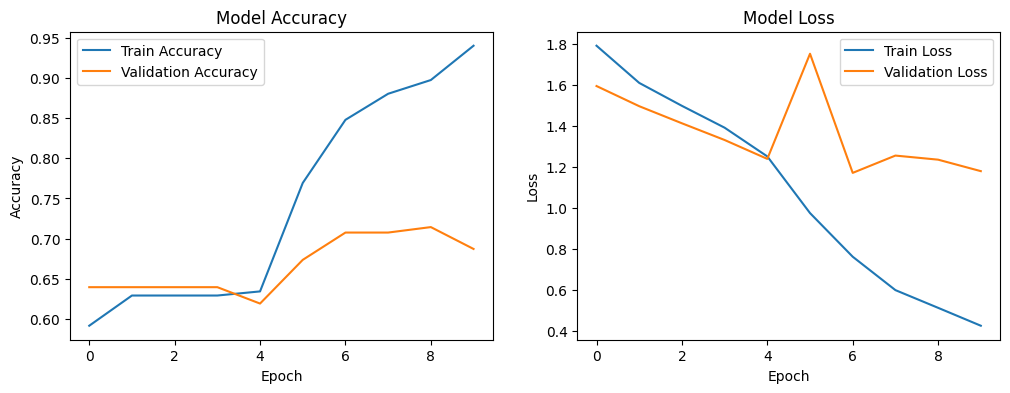

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
              precision    recall  f1-score   support

    Negative       0.57      0.77      0.65        39
     Neutral       0.00      0.00      0.00        14
    Positive       0.79      0.79      0.79        94

    accuracy                           0.71       147
   macro avg       0.45      0.52      0.48       147
weighted avg       0.65      0.71      0.68       147



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


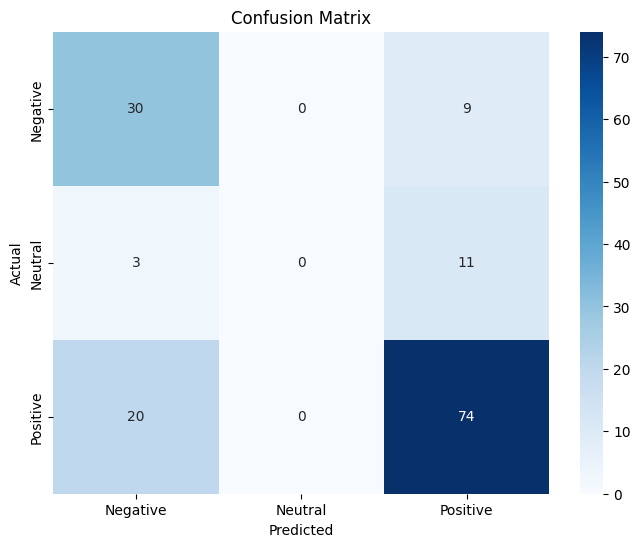

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)

# Generate predictions
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Hyperparameter Tuning with Kerastuner

In [45]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.1 MB/s eta 0:00:00


In [58]:
import tensorflow as tf
import keras_tuner as kt

# Define the model-building function for KerasTuner
def model_builder(hp):  # 'hp' is passed as an argument here
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,
                                        hp.Int('embedding_dim', min_value=64, max_value=256, step=64),
                                        input_length=max_length))

    # Tune the number of LSTM units
    hp_units = hp.Int('units', min_value=32, max_value=128, step=32)  # Now 'hp' is accessible
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hp_units, return_sequences=True)))
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.7, step=0.2)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hp_units)))  # Second Bidirectional LSTM
    model.add(tf.keras.layers.Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.7, step=0.2)))

    # Tune the number of units in the dense layer
    model.add(tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Initialize the tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,  # You can adjust this
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

# Perform hyperparameter search
tuner.search(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))

Reloading Tuner from my_dir/intro_to_kt/tuner0.json
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.5267 - loss: 1.0037 - val_accuracy: 0.6395 - val_loss: 0.8120
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7391 - loss: 0.6295 - val_accuracy: 0.7007 - val_loss: 0.9276
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8536 - loss: 0.3697 - val_accuracy: 0.7279 - val_loss: 0.8184
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9130 - loss: 0.2252 - val_accuracy: 0.7211 - val_loss: 0.9951
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9843 - loss: 0.0574 - val_accuracy: 0.7483 - val_loss: 1.4314
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9861 - loss: 0.0544 - val_accuracy: 0.7551 - val_loss: 1.4178
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9753 - loss: 0.0812 - val_accuracy: 0.6803 - val_loss: 1.2319
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9879 - loss: 0.0423 - val_accuracy: 0.7347 - val_loss: 1.

In [59]:
# Add CNN layer for feature extraction
# Get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
units = best_hps.get('units')  # Get the 'units' value from best_hps
dropout_rate = best_hps.get('dropout_1')  # Get the 'dropout_1' value from best_hps
dense_units = best_hps.get('dense_units')  # Get the 'dense_units' value from best_hps

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),  # CNN layer
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True)), # Use the 'units' variable here
    tf.keras.layers.Dropout(dropout_rate), # Use the 'dropout_rate' variable here
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units)),  # Use the 'units' variable here
    tf.keras.layers.Dropout(dropout_rate), # Use the 'dropout_rate' variable here
    tf.keras.layers.Dense(dense_units, activation='relu'), # Use the 'dense_units' variable here
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [60]:
# attention Mechanism
from tensorflow.keras.layers import Layer
import tensorflow as tf

class Attention(Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector

In [63]:
# ... (other layers) ...

# Define the LSTM layer but don't add it yet
lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=True, dropout=dropout_rate))

# Define the attention layer
attention_layer = Attention(units)

# Build the model with input shape to allow for shape inference
# model.build(input_shape=(None, max_length))  # Remove this line

# Define input layer
input_layer = tf.keras.layers.Input(shape=(max_length,))  # Specify the shape

# Pass the input through the embedding layer
embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim)(input_layer)

# Now add the LSTM and attention layers to the model
lstm_output = lstm_layer(embeddings)
# Get output of LSTM layer
# lstm_output = lstm_layer.output # Get output directly from the LSTM layer

# Assuming hidden_state from the last timestep of the LSTM
hidden_state = tf.keras.layers.Lambda(lambda x: x[:, -1, :])(lstm_output)
context_vector = attention_layer(lstm_output, hidden_state)

# Concatenate context_vector and hidden_state
merged_output = tf.keras.layers.Concatenate()([context_vector, hidden_state])

# Add the remaining dense layers
output = tf.keras.layers.Dense(dense_units, activation='relu')(merged_output)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(output)

# Define the model
model = tf.keras.Model(inputs=input_layer, outputs=output)



In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/aurum/sentimentdataset_with_scores.csv')
display(df.head())

# Clean the text data
def clean_text(text):
    text = str(text).lower().strip()
    # Add more cleaning steps as needed (remove special chars, URLs, etc.)
    return text

df['cleaned_text'] = df['Text'].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['sentiment_category'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['encoded_label'],
    test_size=0.2,
    random_state=42
)

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100  # You can adjust this
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Vocabulary size and embedding dimensions
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 64 # or units from tuner if you used it

# Attention mechanism class (as defined before)
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector
# Build the model using Functional API with Attention
input_layer = tf.keras.layers.Input(shape=(max_length,)) # This line was not indented correctly
embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim)(input_layer)

lstm_output = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(lstm_units, return_sequences=True)
)(embeddings)

attention_output = Attention(lstm_units)(lstm_output, lstm_output[:, -1, :])

# Concatenate attention output and last hidden state of LSTM
merged_output = tf.keras.layers.Concatenate()([attention_output, lstm_output[:, -1, :]])

output = tf.keras.layers.Dense(64, activation='relu')(merged_output)
output = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(output)

model = tf.keras.Model(inputs=input_layer, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_padded, y_train, epochs=20, validation_data=(test_padded, y_test),
                    batch_size=64, callbacks=[early_stopping])

,unnamed,Text,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,sentiment_score,sentiment_category
0,1,Enjoying a beautiful day at the park! ...,1/15/2023 12:30,User123,Twitter,#Nature #Park,15,30,USA,2023,1,15,12,0.8221,Positive
1,2,Traffic was terrible this morning. ...,1/15/2023 8:45,CommuterX,Twitter,#Traffic #Morning,5,10,Canada,2023,1,15,8,-0.4767,Negative
2,3,Just finished an amazing workout! ?? ...,1/15/2023 15:45,FitnessFan,Instagram,#Fitness #Workout,20,40,USA,2023,1,15,15,0.6654,Positive
3,4,Excited about the upcoming weekend getaway! ...,1/15/2023 18:20,AdventureX,Facebook,#Travel #Adventure,8,15,UK,2023,1,15,18,0.4003,Positive
4,5,Trying out a new recipe for dinner tonight. ...,1/15/2023 19:55,ChefCook,Instagram,#Cooking #Food,12,25,Australia,2023,1,15,19,0.0000,Neutral


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 100, 128)  │    292,736 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_19    │ (None, 100, 128)  │     98,816 │ embedding_8[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128)       │          0 │ bidirectional_19… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_6         │ (None, 128)       │     16,577 │ bidirectional_19… │
│ (Attention)         │                   │            │ get_item[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128)       │          0 │ bidirectional_19… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ attention_6[0][0… │
│ (Concatenate)       │                   │            │ get_item_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 64)        │     16,448 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 3)         │        195 │ dense_35[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 424,772 (1.62 MB)

 Trainable params: 424,772 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.5345 - loss: 1.0081 - val_accuracy: 0.6395 - val_loss: 0.8673
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6187 - loss: 0.9175 - val_accuracy: 0.6395 - val_loss: 0.8786
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6127 - loss: 0.9102 - val_accuracy: 0.6395 - val_loss: 0.8647
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6385 - loss: 0.8765 - val_accuracy: 0.6395 - val_loss: 0.8611
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6112 - loss: 0.9127 - val_accuracy: 0.6395 - val_loss: 0.8624
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6240 - loss: 0.8953 - val_accuracy: 0.6395 - val_loss: 0.8622
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6342 - loss: 0.8752 - val_accuracy: 0.6395 - val_loss: 0.8456
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6137 - loss: 0.8322 - val_accuracy: 0.6667 - v

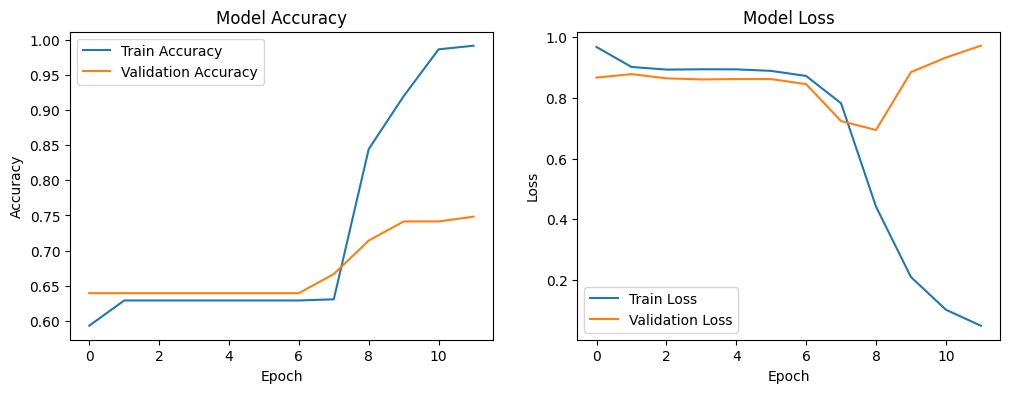

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
              precision    recall  f1-score   support

    Negative       0.55      0.85      0.67        39
     Neutral       0.00      0.00      0.00        14
    Positive       0.83      0.77      0.80        94

    accuracy                           0.71       147
   macro avg       0.46      0.54      0.49       147
weighted avg       0.68      0.71      0.69       147



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


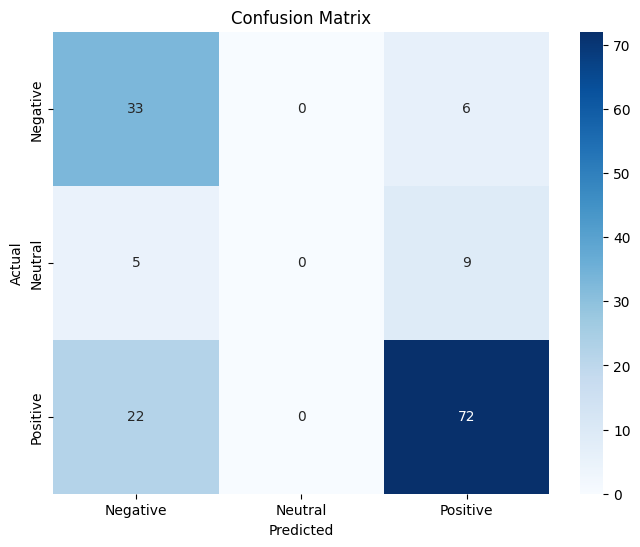

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

plot_history(history)

# Generate predictions
y_pred = model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

save the model

In [ ]:
import pickle

# Save the model
model.save('sentiment_lstm_model.h5')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)